# XGBoost Classifier Model

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


In [2]:
# Load the data
df = pd.read_csv('/Users/sabrinasayed/Documents/GitHub/Fake-Job-Posts/Data/Final_Cleaned_Data.csv')


In [3]:
df.head()

,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,...,requirements_urgency_score,requirements_guarantee_score,requirements_pressure_score,requirements_excessive_punctuation,requirements_all_caps_words,benefits_urgency_score,benefits_guarantee_score,benefits_pressure_score,benefits_excessive_punctuation,benefits_all_caps_words
0,marketing intern,Marketing,food created groundbreaking award winning cook...,food fast growing james beard award winning on...,experience content management system major plu...,NaN,0,1,0,Other,...,0,0,0,0,0,0,0,0,0,0
1,customer service cloud video production,Success,second world cloud video production service se...,organised focused vibrant awesome passion cust...,expect key responsibility communicate client s...,get usthrough part second team gain experience...,0,1,0,Full-time,...,0,0,0,0,0,0,0,0,0,0
2,commissioning machinery assistant cma,NaN,valor service provides workforce solution meet...,client located houston actively seeking experi...,implement pre commissioning commissioning proc...,NaN,0,1,0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,account executive washington dc,Sales,passion improving quality life geography heart...,company esri environmental system research ins...,education bachelor master gi business administ...,culture anything corporatewe collaborative cre...,0,1,0,Full-time,...,0,0,0,0,0,0,0,0,0,0
4,bill review manager,NaN,spotsource solution llc global human capital m...,job title itemization review managerlocation f...,qualification rn license state texasdiploma ba...,full benefit offered,0,1,1,Full-time,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Replace nans with  ''
df = df.fillna('')

In [5]:
df.isna().value_counts()

title  department  company_profile  description  requirements  benefits  telecommuting  has_company_logo  has_questions  employment_type  required_experience  required_education  industry  function  fraudulent  description_length  title_urgency_score  title_guarantee_score  title_pressure_score  title_excessive_punctuation  title_all_caps_words  company_profile_urgency_score  company_profile_guarantee_score  company_profile_pressure_score  company_profile_excessive_punctuation  company_profile_all_caps_words  description_urgency_score  description_guarantee_score  description_pressure_score  description_excessive_punctuation  description_all_caps_words  requirements_urgency_score  requirements_guarantee_score  requirements_pressure_score  requirements_excessive_punctuation  requirements_all_caps_words  benefits_urgency_score  benefits_guarantee_score  benefits_pressure_score  benefits_excessive_punctuation  benefits_all_caps_words
False  False       False            False        False 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 41 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   title                                  17880 non-null  object
 1   department                             17880 non-null  object
 2   company_profile                        17880 non-null  object
 3   description                            17880 non-null  object
 4   requirements                           17880 non-null  object
 5   benefits                               17880 non-null  object
 6   telecommuting                          17880 non-null  int64 
 7   has_company_logo                       17880 non-null  int64 
 8   has_questions                          17880 non-null  int64 
 9   employment_type                        17880 non-null  object
 10  required_experience                    17880 non-null  object
 11  required_educat

In [7]:
text = ['title','company_profile','description','requirements','benefits']

numerical = numerical = df.select_dtypes(include=['int64']).drop('fraudulent', axis=1).columns.tolist()
categorical = ['department', 'employment_type','required_experience', 'required_education', 'industry']


In [8]:
numerical

['telecommuting',
 'has_company_logo',
 'has_questions',
 'description_length',
 'title_urgency_score',
 'title_guarantee_score',
 'title_pressure_score',
 'title_excessive_punctuation',
 'title_all_caps_words',
 'company_profile_urgency_score',
 'company_profile_guarantee_score',
 'company_profile_pressure_score',
 'company_profile_excessive_punctuation',
 'company_profile_all_caps_words',
 'description_urgency_score',
 'description_guarantee_score',
 'description_pressure_score',
 'description_excessive_punctuation',
 'description_all_caps_words',
 'requirements_urgency_score',
 'requirements_guarantee_score',
 'requirements_pressure_score',
 'requirements_excessive_punctuation',
 'requirements_all_caps_words',
 'benefits_urgency_score',
 'benefits_guarantee_score',
 'benefits_pressure_score',
 'benefits_excessive_punctuation',
 'benefits_all_caps_words']

In [9]:
print(df[numerical].shape)
print(df[categorical].shape)
print(df[text].shape)


(17880, 29)
(17880, 5)
(17880, 5)


In [10]:
text

['title', 'company_profile', 'description', 'requirements', 'benefits']

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder

# Create separate transformers for each text column
text_transformers = []
for col in text:
    text_transformers.append(
        (f'tfidf_{col}', TfidfVectorizer(
            min_df=0.01, 
            max_df=0.95, 
            ngram_range=(1, 3), 
            stop_words='english'
        ), col)  # Note: passing col directly, not [col]
    )

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', TargetEncoder(), categorical),
        *text_transformers
    ],
    remainder='drop',
    sparse_threshold=0  # Force dense output
)

# Build pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(random_state=42))
])

# Split the data
X = df[numerical + categorical + text]
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
xgb = pipeline.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3395
           1       0.93      0.77      0.84       181

    accuracy                           0.99      3576
   macro avg       0.96      0.88      0.92      3576
weighted avg       0.98      0.99      0.98      3576

0.9854586129753915


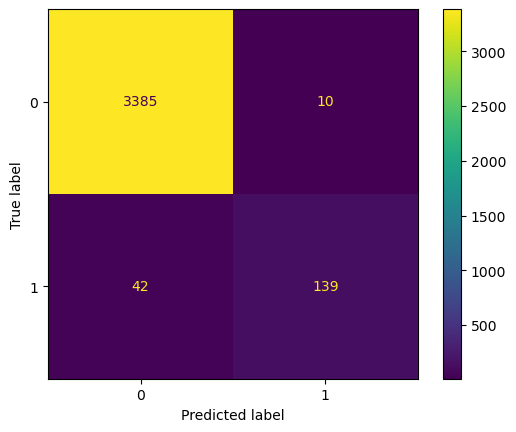

In [12]:

# Evaluate the model
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)

The F1 score is 91% and 98% accuracy.

# GridSearchCV Tuning

In [13]:
param_test1 = {
    "classifier__max_depth": range(3,6,10),
    "classifier__min_child_weight": range(1,3,5),
    "classifier__subsample": [0.8,0.9],
    "classifier__n_estimators": range(100,500,1000),
    "classifier__learning_rate": [.01,.1]
}

gsearch1 = GridSearchCV(
    estimator=pipeline,  # Use the full pipeline here
    param_grid=param_test1,
    n_jobs=2,
    cv=3,
    scoring='f1'
)

gsearch1.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['telecommuting',
                                                                          'has_company_logo',
                                                                          'has_questions',
                                                                          'description_length',
                                                                          'title_urgency_score',
                                                                          'title_guarantee_score',
                                                                          'title_pressure_score',
                                                                          'title_excessive_punctuation',
                                                                          'title_all_caps_words',
                                                                          'company_profile_urg...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': range(3, 6, 10),
                         'classifier__min_child_weight': range(1, 3, 5),
                         'classifier__n_estimators': range(100, 500, 1000),
                         'classifier__subsample': [0.8, 0.9]},
             scoring='f1')

In [14]:
# Best parameters
print(gsearch1.best_params_)


{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 100, 'classifier__subsample': 0.9}


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.93      0.62      0.75       181

    accuracy                           0.98      3576
   macro avg       0.96      0.81      0.87      3576
weighted avg       0.98      0.98      0.98      3576

0.9787472035794184


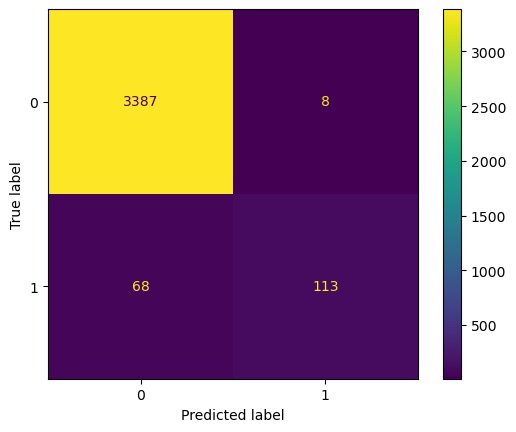

In [15]:
# Evaluate the model
y_pred = gsearch1.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(gsearch1, X_test, y_test)

The F1 went down and the accuracy is the same. Hoowever the recall for teh minority class went down. I think the original untuned model is better because it recognizes the minority class more often. 

In [16]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(np.exp(y_pred), np.exp(y_test))
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

RMSE: 0.2504969476927791


### Tuning with SMOTE 

In [17]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", XGBClassifier())
])

param_test2 = {
    "smote__k_neighbors": [3, 5, 7]
}

gsearch2 = GridSearchCV(
    estimator=pipeline,
    param_grid=param_test2,
    n_jobs=2,
    cv=3,
    scoring='f1')

gsearch2.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['telecommuting',
                                                                          'has_company_logo',
                                                                          'has_questions',
                                                                          'description_length',
                                                                          'title_urgency_score',
                                                                          'title_guarantee_score',
                                                                          'title_pressure_score',
                                                                          'title_excessive_punctuation',
                                                                          'title_all_caps_words',
                                                                          'company_profile_urg...
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=2, param_grid={'smote__k_neighbors': [3, 5, 7]},
             scoring='f1')

In [18]:
# Best parameters
print(gsearch2.best_params_)

{'smote__k_neighbors': 7}


In [33]:
best_pipeline =gsearch2.best_estimator_

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3395
           1       0.80      0.83      0.81       181

    accuracy                           0.98      3576
   macro avg       0.89      0.91      0.90      3576
weighted avg       0.98      0.98      0.98      3576

0.9807046979865772
RMSE: 0.23868228539416284


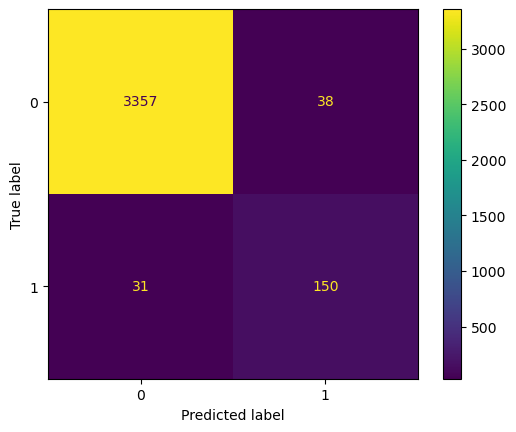

In [19]:
# Evaluate the model
y_pred_2= gsearch2.predict(X_test)
print(classification_report(y_test, y_pred_2))
print(accuracy_score(y_test, y_pred_2))
ConfusionMatrixDisplay.from_estimator(gsearch2, X_test, y_test)


mse = mean_squared_error(np.exp(y_pred_2), np.exp(y_test))
rmse2 = np.sqrt(mse)
print(f"RMSE: {rmse2}")


# Best Model Evaluation:

With the GridSearchCV Pipeline tuned with SMOTE, accuracy stayed the same and the F1 score went down, but we gained a stronger recall of the minority class. In our case, we want to be able to identify fraudulent posts as often as possible, so we need to prioritize recall score. For that reason, this model is the best performing one, since it gives us the best recall score of the minority class. The error also went down.

### Accuracy: 98%
### F1 Score: 90%
### Minority Recall: 83%
### RMSE: 0.23


# ROC and AUC Analysis

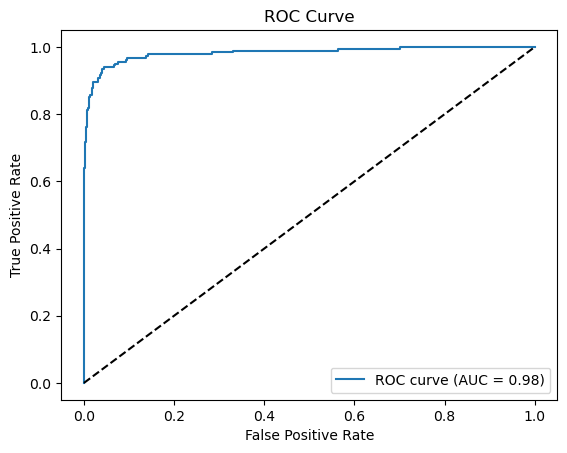

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, gsearch2.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('/Users/sabrinasayed/Documents/GitHub/Fake-Job-Posts/Images/ROC_AUC_Curve.png')

The  Area Under the Curve is very high showing the model is good at discriminating between fraudulent and legitimate posts. Based on the shape of the curve, the model has a high true positive rate and a low false positive rate. The model is highly reliable for fraud detection.

# Precision-Recall Curve

Text(0.5, 1.0, 'Precision-Recall Curve')

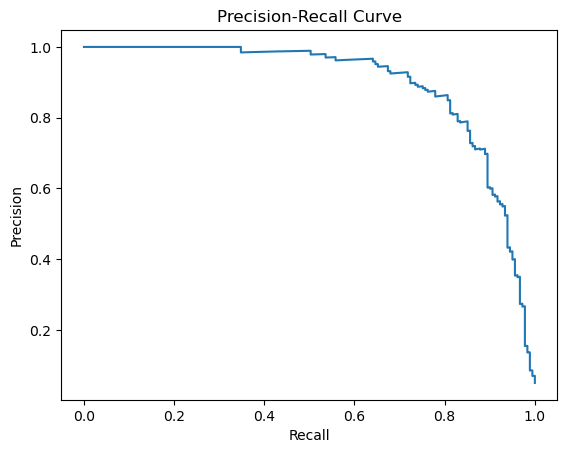

In [25]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, gsearch2.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

The model has high precision while capturing about 40% of the fraudulent posts. There is some tradeoff between catching more fraudulent posts vs maintaing accuracy. After 80% recall the precision drops off dramatically.

# Topic Modeling


In [56]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def prepare_text_for_lda(df):
    # Combine text columns into single documents
    text_data = df.apply(
        lambda x: ' '.join([
            str(x['title']), 
            str(x['company_profile']), 
            str(x['description']), 
            str(x['requirements']), 
            str(x['benefits'])
        ]), 
        axis=1
    )
    
    # Convert to list of strings and ensure all entries are strings
    text_data = [str(text) for text in text_data]
    
    # Basic cleaning
    text_data = [text.lower() for text in text_data]  # lowercase
    text_data = [text.replace('\n', ' ') for text in text_data]  # remove newlines
    
    return text_data
# Prepare the text data
text_data = prepare_text_for_lda(df)

# More lenient parameters for CountVectorizer
vectorizer = CountVectorizer(
    max_df=0.99,  # Increased from 0.95
    min_df=2,     # Kept at 2 documents minimum
    stop_words='english',
    max_features=5000  # Added to limit vocabulary size
)

try:
    # Print some diagnostic information
    print(f"Number of documents: {len(text_data)}")
    print(f"Sample document length: {len(text_data[0])}")
    print(f"Sample first 100 chars: {text_data[0][:100]}")
    
    # Vectorize
    text_vectorized = vectorizer.fit_transform(text_data)
    
    print(f"\nVocabulary size: {len(vectorizer.get_feature_names_out())}")
    print(f"Document-term matrix shape: {text_vectorized.shape}")
    
    # Fit LDA model
    lda = LatentDirichletAllocation(
        n_components=10,
        random_state=42,
        max_iter=20
    )
    lda.fit(text_vectorized)
    
    # Display topics
    def display_topics(model, feature_names, n_top_words=10):
        for topic_idx, topic in enumerate(model.components_):
            top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
            print(f"\nTopic {topic_idx + 1}:")
            print(", ".join(top_words))
    feature_names = vectorizer.get_feature_names_out()
    display_topics(lda, feature_names)

except ValueError as e:
    print(f"Error occurred: {str(e)}")
    print("\nTry adjusting these parameters:")
    print("1. Decrease min_df (currently 2)")
    print("2. Increase max_df (currently 0.99)")
    print("3. Check if text_data is not empty")

Number of documents: 17880
Sample document length: 1997
Sample first 100 chars: marketing intern food created groundbreaking award winning cooking site support connect celebrate ho

Vocabulary size: 5000
Document-term matrix shape: (17880, 5000)

Topic 1:
job, company, engineering, experience, manufacturing, website, required, technical, quality, position

Topic 2:
service, work, shall, customer, home, career, ensure, year, time, candidate

Topic 3:
job, student, teacher, abroad, experience, required, loan, school, work, amp

Topic 4:
experience, team, design, work, product, web, development, software, technology, developer

Topic 5:
work, team, people, company, opportunity, looking, employee, want, mso, time

Topic 6:
sale, customer, business, product, service, company, client, team, experience, new

Topic 7:
service, work, care, experience, position, amp, time, company, health, home

Topic 8:
customer, service, work, company, process, employment, communication, solution, year, time



# Model Interpretability

In [26]:
numerical

['telecommuting',
 'has_company_logo',
 'has_questions',
 'description_length',
 'title_urgency_score',
 'title_guarantee_score',
 'title_pressure_score',
 'title_excessive_punctuation',
 'title_all_caps_words',
 'company_profile_urgency_score',
 'company_profile_guarantee_score',
 'company_profile_pressure_score',
 'company_profile_excessive_punctuation',
 'company_profile_all_caps_words',
 'description_urgency_score',
 'description_guarantee_score',
 'description_pressure_score',
 'description_excessive_punctuation',
 'description_all_caps_words',
 'requirements_urgency_score',
 'requirements_guarantee_score',
 'requirements_pressure_score',
 'requirements_excessive_punctuation',
 'requirements_all_caps_words',
 'benefits_urgency_score',
 'benefits_guarantee_score',
 'benefits_pressure_score',
 'benefits_excessive_punctuation',
 'benefits_all_caps_words']

In [28]:
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out()
print("Categorical features:", cat_feature_names)

Categorical features: ['department' 'employment_type' 'required_experience' 'required_education'
 'industry']


In [34]:
import scipy.sparse
# Get the vectorizer feature names from the remainder
vectorizer_feature_names = preprocessor.get_feature_names_out()

# Verify the length matches our transformed data
X_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)
if scipy.sparse.issparse(X_transformed):
    X_transformed = X_transformed.toarray()

print("Number of features:", len(vectorizer_feature_names))
print("Transformed data shape:", X_transformed.shape[1])
print("First few feature names:", vectorizer_feature_names[:20])

Number of features: 4954
Transformed data shape: 4954
First few feature names: ['num__telecommuting' 'num__has_company_logo' 'num__has_questions'
 'num__description_length' 'num__title_urgency_score'
 'num__title_guarantee_score' 'num__title_pressure_score'
 'num__title_excessive_punctuation' 'num__title_all_caps_words'
 'num__company_profile_urgency_score'
 'num__company_profile_guarantee_score'
 'num__company_profile_pressure_score'
 'num__company_profile_excessive_punctuation'
 'num__company_profile_all_caps_words' 'num__description_urgency_score'
 'num__description_guarantee_score' 'num__description_pressure_score'
 'num__description_excessive_punctuation'
 'num__description_all_caps_words' 'num__requirements_urgency_score']


In [44]:
import scipy.sparse
# Get the vectorizer feature names from the remainder

vectorizer_feature_names = preprocessor.get_feature_names_out()

# The vectorizer_feature_names should now contain all feature names in the correct order
# Let's verify the length matches our transformed data
X_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)
if scipy.sparse.issparse(X_transformed):
    X_transformed = X_transformed.toarray()

print("Number of features:", len(vectorizer_feature_names))
print("Transformed data shape:", X_transformed.shape[1])
print("First few feature names:", vectorizer_feature_names[:20])
# Get all feature names
feature_names = preprocessor.get_feature_names_out()

# Clean up the feature names
cleaned_features = []
for name in feature_names:
    cleaned_name = name
    # Remove standard prefixes
    for prefix in ['num__', 'cat__', 'tfidf_', 'count_', 'text_']:
        if cleaned_name.startswith(prefix):
            cleaned_name = cleaned_name[len(prefix):]
            break
    
    # Remove specific prefixes
    for prefix in ['description__', 'title__', 'company_profile__', 'requirements__', 'benefits__']:
        if cleaned_name.startswith(prefix):
            cleaned_name = cleaned_name[len(prefix):]
            break
    
    cleaned_features.append(cleaned_name)
# Convert to array for SHAP plot
cleaned_features = np.array(cleaned_features)

print("Number of features:", len(cleaned_features))
print("First few cleaned feature names:", cleaned_features[:20])

Number of features: 4954
Transformed data shape: 4954
First few feature names: ['num__telecommuting' 'num__has_company_logo' 'num__has_questions'
 'num__description_length' 'num__title_urgency_score'
 'num__title_guarantee_score' 'num__title_pressure_score'
 'num__title_excessive_punctuation' 'num__title_all_caps_words'
 'num__company_profile_urgency_score'
 'num__company_profile_guarantee_score'
 'num__company_profile_pressure_score'
 'num__company_profile_excessive_punctuation'
 'num__company_profile_all_caps_words' 'num__description_urgency_score'
 'num__description_guarantee_score' 'num__description_pressure_score'
 'num__description_excessive_punctuation'
 'num__description_all_caps_words' 'num__requirements_urgency_score']
Number of features: 4954
First few cleaned feature names: ['telecommuting' 'has_company_logo' 'has_questions' 'description_length'
 'title_urgency_score' 'title_guarantee_score' 'title_pressure_score'
 'title_excessive_punctuation' 'title_all_caps_words'
 'comp

In [36]:
print(best_pipeline.named_steps)

{'preprocessor': ColumnTransformer(sparse_threshold=0,
                  transformers=[('num', StandardScaler(),
                                 ['telecommuting', 'has_company_logo',
                                  'has_questions', 'description_length',
                                  'title_urgency_score',
                                  'title_guarantee_score',
                                  'title_pressure_score',
                                  'title_excessive_punctuation',
                                  'title_all_caps_words',
                                  'company_profile_urgency_score',
                                  'company_profile_guarantee_score',
                                  'company_profi...
                                 'company_profile'),
                                ('tfidf_description',
                                 TfidfVectorizer(max_df=0.95, min_df=0.01,
                                                 ngram_range=(1, 3),
       

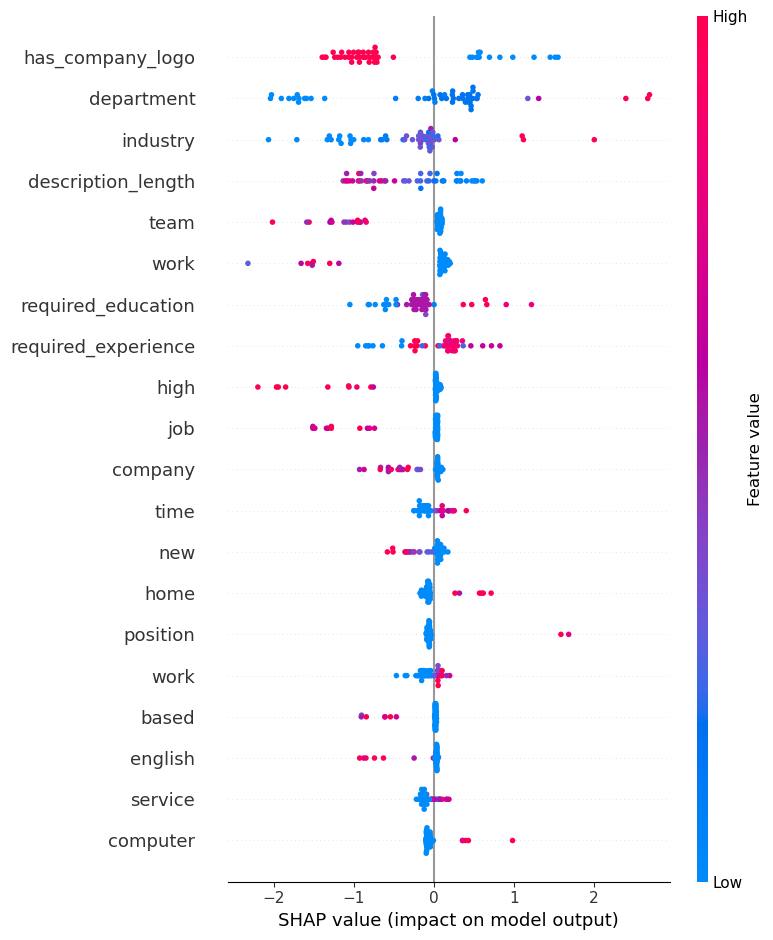

In [45]:
import shap
# Create SHAP plots with cleaned feature names
X_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)
if scipy.sparse.issparse(X_transformed):
    X_transformed = X_transformed.toarray()

explainer = shap.TreeExplainer(best_pipeline.named_steps['classifier'])
shap_values = explainer(X_transformed[:50])
shap.summary_plot(shap_values, X_transformed[:50], feature_names=cleaned_features)

## Interpreting SHAP Summary Plot:

- Red dots indicate high feature values
- Blue dots indicate low feature values
- Position left of center (negative SHAP value) suggests fraud
- Position right of center (positive SHAP value) suggests legitimate posting

Most Influential Features for prediction:
- has_company_logo: when this is not present, it pushes the predictions toward fraud (positive SHAP values). This makes sence because fraudulent posts are less likely to have company logos
- department: Shows significant spread, indicating different departments have varying levels of risk
- industry: Moderate impact with some industries being more associated with fraudulent posts
- description_length: Longer descriptions (red) tend to indicate legitimate posts

Mid-Level Impact Features:
- team and work related terms: Their presence generally indicates legitimate posts
- required_education and required_experience: More detailed requirements typically suggest legitimate posts
- high: Shows some clustering, suggesting certain high-level positions may be more prone to fraud

Lower Impact Features:
- Terms like position, based, english, service, and computer have smaller but still meaningful impacts
- home: Slight correlation with fraud when present
- time: Shows mixed impact depending on context


The model relies heavily on structural features (like company logo presence) and content-based features (like description length and specific terminology) to identify fraudulent job postings.

# Model Interpretability: LIME

In [47]:
import lime
import lime.lime_tabular

# Create a LIME explainer

X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
if scipy.sparse.issparse(X_train_transformed):
    X_train_transformed = X_train_transformed.toarray()

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_transformed,
    feature_names=cleaned_features, 
    class_names=['Legitimate', 'Fraudulent'],
    mode='classification'
)

In [50]:
# Function to get predictions from pipeline
def pipeline_predict_proba(X):
    if len(X.shape) == 1:
        X = X.reshape(1, -1)
    return best_pipeline.named_steps['classifier'].predict_proba(X)

# Picking one sample to explain on
X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)
if scipy.sparse.issparse(X_test_transformed):
    X_test_transformed = X_test_transformed.toarray()

# Get explanation for a single instance
instance_idx = 0 
exp = explainer.explain_instance(
    X_test_transformed[instance_idx], 
    pipeline_predict_proba,
    num_features=10  # Show 10 features
)


In [51]:
# Visualize the explanation
exp.show_in_notebook()

# Print the prediction probability
print("\nActual class:", y_test.iloc[instance_idx])
print("Predicted probabilities:", pipeline_predict_proba(X_test_transformed[instance_idx]))


Actual class: 0
Predicted probabilities: [[0.99870646 0.00129354]]


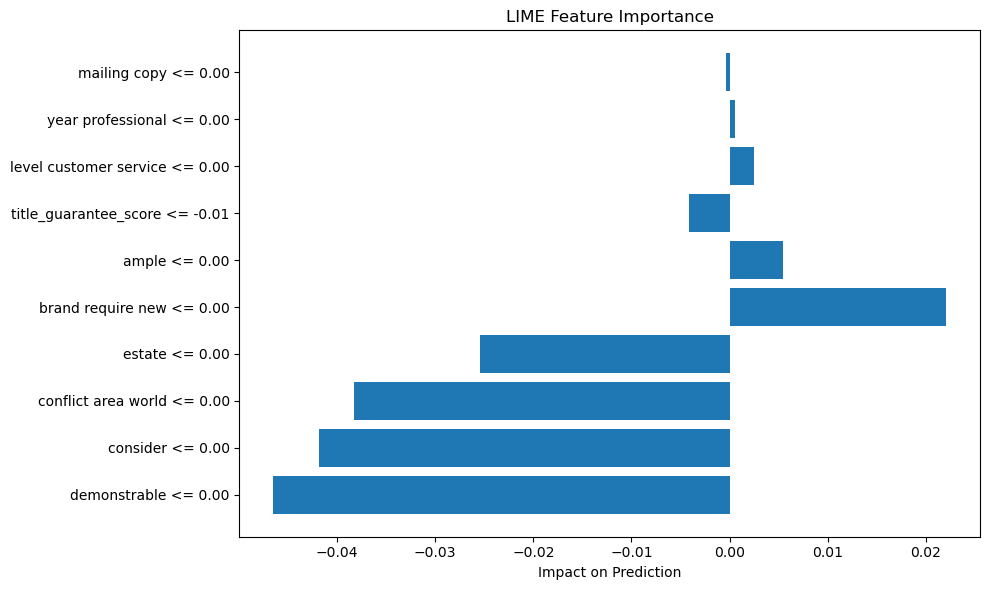

In [57]:
# Save prediction details

# Save the HTML visualization
explanation_html = exp.as_html()
with open('lime_explanation.html', 'w') as f:
    f.write(explanation_html)

# Save feature importances as CSV
feature_importance_df = pd.DataFrame(
    exp.as_list(), 
    columns=['Feature', 'Importance']
).sort_values('Importance', key=abs, ascending=False)

feature_importance_df.to_csv('feature_importances.csv', index=False)

# Plot feature importances
import matplotlib.pyplot as plt
import json

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('LIME Feature Importance')
plt.xlabel('Impact on Prediction')
plt.tight_layout()
#plt.savefig('/Users/sabrinasayed/Documents/GitHub/Fake-Job-Posts/Images/lime_feature_importance.png')

# Interpreting LIME Feature Importance

- Words/phrases associated with vague or potentially suspicious circumstances (like "conflict area world" or "demonstrable") are strong indicators of fraudulent posts
- Professional terminology and specific job requirements (like "brand require new") tend to indicate legitimate postings



In [59]:

# Save prediction details
prediction_summary = {
    'feature_importances': exp.as_list(),
    'class_names': exp.class_names,
    'predicted_class': exp.class_names[exp.predict_proba.argmax()],
    'prediction_probabilities': {
        'legitimate': float(exp.predict_proba[0]),  # Convert to float for JSON serialization
        'fraudulent': float(exp.predict_proba[1])
    }
}

# Save as JSON
with open('lime_explanation.json', 'w') as f:
    json.dump(prediction_summary, f, indent=2)

# Analyze another instance with LIME


Actual class: 0
Predicted probabilities: [[9.9966353e-01 3.3647049e-04]]


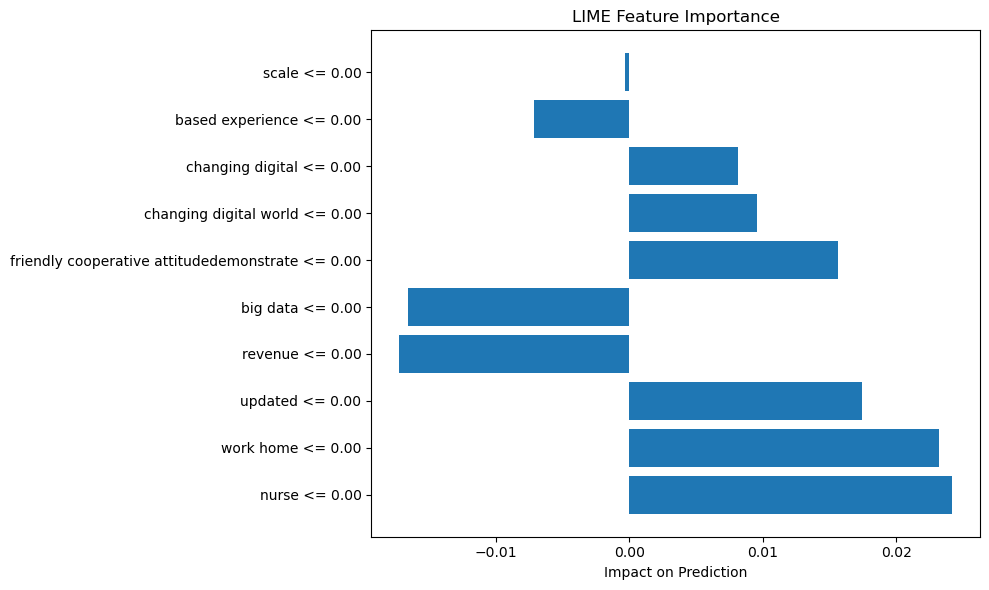

In [61]:
# Get explanation for a single instance
instance_idx = 100 
exp = explainer.explain_instance(
    X_test_transformed[instance_idx], 
    pipeline_predict_proba,
    num_features=10  # Show 10 features
)

# Visualize the explanation
exp.show_in_notebook()

# Print the prediction probability
print("\nActual class:", y_test.iloc[instance_idx])
print("Predicted probabilities:", pipeline_predict_proba(X_test_transformed[instance_idx]))

# Save the HTML visualization
explanation_html = exp.as_html()
with open('lime_explanation_2.html', 'w') as f:
    f.write(explanation_html)

# Save feature importances as CSV
feature_importance_df_2 = pd.DataFrame(
    exp.as_list(), 
    columns=['Feature', 'Importance']
).sort_values('Importance', key=abs, ascending=False)

feature_importance_df_2.to_csv('feature_importances_2.csv', index=False)

# Plot feature importances
import matplotlib.pyplot as plt
import json

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_2['Feature'], feature_importance_df_2['Importance'])
plt.title('LIME Feature Importance')
plt.xlabel('Impact on Prediction')
plt.tight_layout()

- Healthcare-related terms (nurse) strongly indicate legitimacy
- Remote work terminology ("work home") is a strong legitimate indicator
- Professional attributes ("friendly cooperative attitude") contribute to legitimacy
- Digital transformation related terms show mixed but generally positive impacts

This suggests the model has learned that healthcare job postings and well-detailed remote work opportunities tend to be legitimate, while being cautious of postings that heavily emphasize business/revenue terms without proper context. It also shows how descriptive posts about work environments and company culture can be indicators of legitimacy.

In [58]:
# Add topic information to LIME explanation
def explain_with_topics(instance_idx, X_test, pipeline, explainer, lda, text_vectorized):
    # Get topic distribution for this instance
    instance_topics = lda.transform(text_vectorized[X_test.index[instance_idx]].reshape(1, -1))
    
    # Get LIME explanation
    exp = explainer.explain_instance(
        X_test_transformed[instance_idx],
        pipeline_predict_proba,
        num_features=10
    )
    
    # Print dominant topics
    print("\nDominant Topics:")
    top_topics = np.argsort(instance_topics[0])[-3:][::-1]
    for topic_idx in top_topics:
        print(f"Topic {topic_idx + 1}: {instance_topics[0][topic_idx]:.3f}")
    
    return exp

# Use in your case analysis
exp = explain_with_topics(instance_idx, X_test, best_pipeline, explainer, lda, text_vectorized)



Dominant Topics:
Topic 4: 0.904
Topic 9: 0.090
Topic 3: 0.001


# Case Analysis

In [60]:
# Function to analyze specific cases
def analyze_specific_cases(condition='wrong_predictions', num_cases=5):
    """
    condition can be:
    - 'wrong_predictions': cases where model was wrong
    - 'high_confidence': cases with highest prediction confidence
    - 'low_confidence': cases with lowest prediction confidence
    """
    y_pred_proba = pipeline_predict_proba(X_test_transformed)
    
    if condition == 'wrong_predictions':
        y_pred_2 = (y_pred_proba[:, 1] > 0.5).astype(int)
        wrong_indices = np.where(y_pred_2 != y_test)[0]
        indices = wrong_indices[:num_cases]
    elif condition == 'high_confidence':
        confidence = np.max(y_pred_proba, axis=1)
        indices = np.argsort(confidence)[-num_cases:]
    else:  # low_confidence
        confidence = np.max(y_pred_proba, axis=1)
        indices = np.argsort(confidence)[:num_cases]
    
    for idx in indices:
        print(f"\nAnalyzing {'Wrong' if condition == 'wrong_predictions' else 'Case'} #{idx}")
        print("-" * 50)
        exp = explainer.explain_instance(
            X_test_transformed[idx],
            pipeline_predict_proba,
            num_features=5
        )
        print(f"Actual: {'Fraudulent' if y_test.iloc[idx] == 1 else 'Legitimate'}")
        print(f"Predicted probability of fraud: {y_pred_proba[idx][1]:.3f}")
        print("\nFeature contributions:")
        for feature, value in exp.as_list():
            print(f"{feature}: {value:0.3f}")

# Analyze wrong predictions
print("Analyzing Wrong Predictions:")
analyze_specific_cases('wrong_predictions')

# Analyze high confidence predictions
print("\nAnalyzing High Confidence Predictions:")
analyze_specific_cases('high_confidence')

Analyzing Wrong Predictions:

Analyzing Wrong #18
--------------------------------------------------
Actual: Fraudulent
Predicted probability of fraud: 0.048

Feature contributions:
required_experience <= 0.03: -0.057
work <= 0.00: 0.044
team <= 0.00: 0.032
required_education <= 0.02: -0.032
new <= 0.00: 0.027

Analyzing Wrong #67
--------------------------------------------------
Actual: Legitimate
Predicted probability of fraud: 0.800

Feature contributions:
industry > 0.06: 0.070
home <= 0.00: -0.043
0.03 < required_experience <= 0.06: 0.042
high <= 0.00: 0.042
work <= 0.00: 0.039

Analyzing Wrong #90
--------------------------------------------------
Actual: Legitimate
Predicted probability of fraud: 0.571

Feature contributions:
department > 0.05: 0.121
0.03 < required_experience <= 0.06: 0.044
high <= 0.00: 0.043
work <= 0.00: 0.042
new <= 0.00: 0.026

Analyzing Wrong #101
--------------------------------------------------
Actual: Legitimate
Predicted probability of fraud: 0.722


# Takeaways from LIME Case Analysis:

## Key Patterns in Wrong Predictions 

- Presence of professional terms ("work", "team") strongly influenced legitimate classification
- Most fraudulent cases are predicted with very low fraud probabilities (0.009-0.071)
- Higher industry/department values triggered fraud signals
- Required experience in certain ranges (0.03-0.06) consistently flagged as suspicious
- Absence of terms like "work", "high", and "team" contributed to fraud classification
- Description length played a minor role


## High Confidence Correct Predictions 

- Low department values consistently indicate legitimate posts
- Presence of professional terminology ("work", "team")
- Appropriate experience and education requirements
- Longer description lengths

## Feature Importance Patterns:
- Department and experience requirements are highly influential
- Professional terminology ("work", "team") strongly influences classification
- Description length has moderate impact

## Model Confusion Patterns
- Struggles with posts that mix legitimate and suspicious indicators
- Can be overly sensitive to certain ranges of numerical features
- Sometimes overweights absence of common terms

### Feature Interactions:
- "growing" shows interesting behavior: sometimes indicates fraud, sometimes legitimacy
- "medium" appears in both wrong and right predictions with varying effects
- "Topic 9" appears multiple times with moderate influence


# Recommendations for Improvement:

## Feature Engineering:
- Develop compound features that combine multiple weak signals
- Add more context-aware features of department and industry values

## Model Adjustments:
- Better handling of experience requirement ranges
- Improved balance between textual and numerical features
- Better context understanding for professional terminology

## Data Collection:
- Gather more examples of subtle fraud cases
- Focus on cases where offshore and link appear in legitimate contexts
- Collect more data where growing is a reliable indicator of legitimacy


# Conclusion:

This model is overly simplistic in its decision making. It's mainly looking for presence/absence of individual words without any context which leads to confusing patterns. 

# Practical Recommendations:

### Job seekers should be cautious of offshore opportunities, verify company claims (should have a company logo), be wary of overly casual or aggressive language, and double check any external links

### Hiring platforms should implement extra verification for posts mentioning offshore work, add additional scruitiny to postings using big company names, monitor link patterns and exteernal URL usage, and flag posts with unusual language patterns

### Employers should aim to use industry-specific terminology, maintain professional language, provide verifiable company information, and be transparent about work locations.

# Saving Pipeline

In [64]:
from joblib import dump, load
import os
from datetime import datetime
from sklearn.metrics import f1_score, accuracy_score

# Save the best model (from GridSearchCV with SMOTE)
model_dir = '/Users/sabrinasayed/Documents/GitHub/Fake-Job-Posts/Models'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)


# Save metadata
feature_importances = best_pipeline.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': cleaned_features,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

best_model_metadata = {
    'feature names':cleaned_features.tolist(),
    'numerical_features': numerical,
    'categorical_features': categorical,
    'text_features': text,
    'model_type': 'XGBoost with SMOTE',
    'data_source': 'Final_Cleaned_Data.csv',
    'preprocessing': 'preprocessor',
    'training_date': str(datetime.now()),
    'data_shape': df.shape,
    'performance_metrics': {
        'accuracy': accuracy_score(y_test, y_pred_2),
        'f1_score': f1_score(y_test, y_pred_2),
        'rmse': rmse2
    },
     'feature_importances': feature_importance_df.to_dict('records'),
     'best_smote_params': gsearch2.best_params_
}


# Save best pipeline from GridSearchCV
pipeline_path = os.path.join(model_dir, 'best_model_pipeline.joblib')
dump(best_pipeline, pipeline_path)

# Save metadata
metadata_path = os.path.join(model_dir, 'best_model_metadata.joblib')
dump(best_model_metadata, metadata_path)

# Save training data
dump(X_train, os.path.join(model_dir, 'X_train.joblib'))


# Save feature importances
feature_importance_path = os.path.join(model_dir, 'feature_importances.csv')
feature_importance_df.to_csv(feature_importance_path, index=False)

# Save SHAP values
shap_values_path = os.path.join(model_dir, 'shap_values.joblib')
shap_data = {
    'shap_values': shap_values.values,
    'data': X_transformed[:50],
    'feature_names': cleaned_features 
}
dump(shap_data, shap_values_path)

# Save LIME example explanations
lime_path = os.path.join(model_dir, 'lime_examples.joblib')
lime_data = {
    'explanation_1': feature_importance_df,
    'explanation_2': feature_importance_df_2
}
dump(lime_data, lime_path)


print(f"Pipeline saved to {pipeline_path}")
print(f"Metadata saved to {metadata_path}")
print(f"Feature importances saved to {feature_importance_path}")
print(f"SHAP values saved to {shap_values_path}")
print(f"LIME examples saved to {lime_path}")

# Verification
try:
    loaded_pipeline = load(pipeline_path)
    loaded_metadata = load(metadata_path)
    loaded_shap = load(shap_values_path)
    loaded_lime = load(lime_path)
    
    print("\nVerification:")
    print(f"Data source: {loaded_metadata['data_source']}")
    print(f"Data shape: {loaded_metadata['data_shape']}")
    print(f"Number of features: {len(loaded_metadata['feature_importances'])}")
    print(f"Model type: {loaded_metadata['model_type']}")
    print(f"Best SMOTE parameters: {loaded_metadata['best_smote_params']}")
    
    # Make test prediction
    test_pred = loaded_pipeline.predict_proba(X_test[:1])
    print("Test prediction successful!")

except Exception as e:
    print(f"Error during verification: {str(e)}")



Pipeline saved to /Users/sabrinasayed/Documents/GitHub/Fake-Job-Posts/Models/best_model_pipeline.joblib
Metadata saved to /Users/sabrinasayed/Documents/GitHub/Fake-Job-Posts/Models/best_model_metadata.joblib
Feature importances saved to /Users/sabrinasayed/Documents/GitHub/Fake-Job-Posts/Models/feature_importances.csv
SHAP values saved to /Users/sabrinasayed/Documents/GitHub/Fake-Job-Posts/Models/shap_values.joblib
LIME examples saved to /Users/sabrinasayed/Documents/GitHub/Fake-Job-Posts/Models/lime_examples.joblib

Verification:
Data source: Final_Cleaned_Data.csv
Data shape: (17880, 41)
Number of features: 4954
Model type: XGBoost with SMOTE
Best SMOTE parameters: {'smote__k_neighbors': 7}
Test prediction successful!
